In [1]:
import torch 
from torch import nn, Tensor

import matplotlib.pyplot as plt
from sklearn.datasets import make_moons
from flow_matching.path.scheduler import CondOTScheduler
from flow_matching.path import AffineProbPath
from flow_matching.solver import Solver, ODESolver
from flow_matching.utils import ModelWrapper

In [2]:
class Flow(nn.Module):
    def __init__(self, dim: int = 2, h: int = 64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(dim + 1, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, h), nn.ELU(),
            nn.Linear(h, dim))
    
    def forward(self, t: Tensor, x_t: Tensor) -> Tensor:
        return self.net(torch.cat((t, x_t), -1))
    
    def step(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = t_start.view(1, 1).expand(x_t.shape[0], 1)
        
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t=x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)

    def step_reverse(self, x_t: Tensor, t_start: Tensor, t_end: Tensor) -> Tensor:
        t_start = 1 - t_start.view(1, 1).expand(x_t.shape[0], 1)
        t_end = 1 - t_end
        return x_t + (t_end - t_start) * self(t=t_start + (t_end - t_start) / 2, x_t=x_t + self(x_t=x_t, t=t_start) * (t_end - t_start) / 2)


In [17]:
flow = Flow()

optimizer = torch.optim.Adam(flow.parameters(), 3e-3)
loss_fn = nn.MSELoss()

path = AffineProbPath(scheduler=CondOTScheduler())

for _ in range(20000):
    x_1 = Tensor(make_moons(256, noise=0.05)[0])
    x_0 = torch.randn_like(x_1)
    t = torch.rand(len(x_1))
    
    path_sample = path.sample(t=t, x_0=x_0, x_1=x_1)
    
    # x_t = (1 - t) * x_0 + t * x_1
    # dx_t = x_1 - x_0
    
    optimizer.zero_grad()
    # loss_fn(flow(t=t, x_t=x_t), dx_t).backward()
    loss = loss_fn(flow(path_sample.t.unsqueeze(1), path_sample.x_t),  path_sample.dx_t)
    loss.backward()
    optimizer.step()

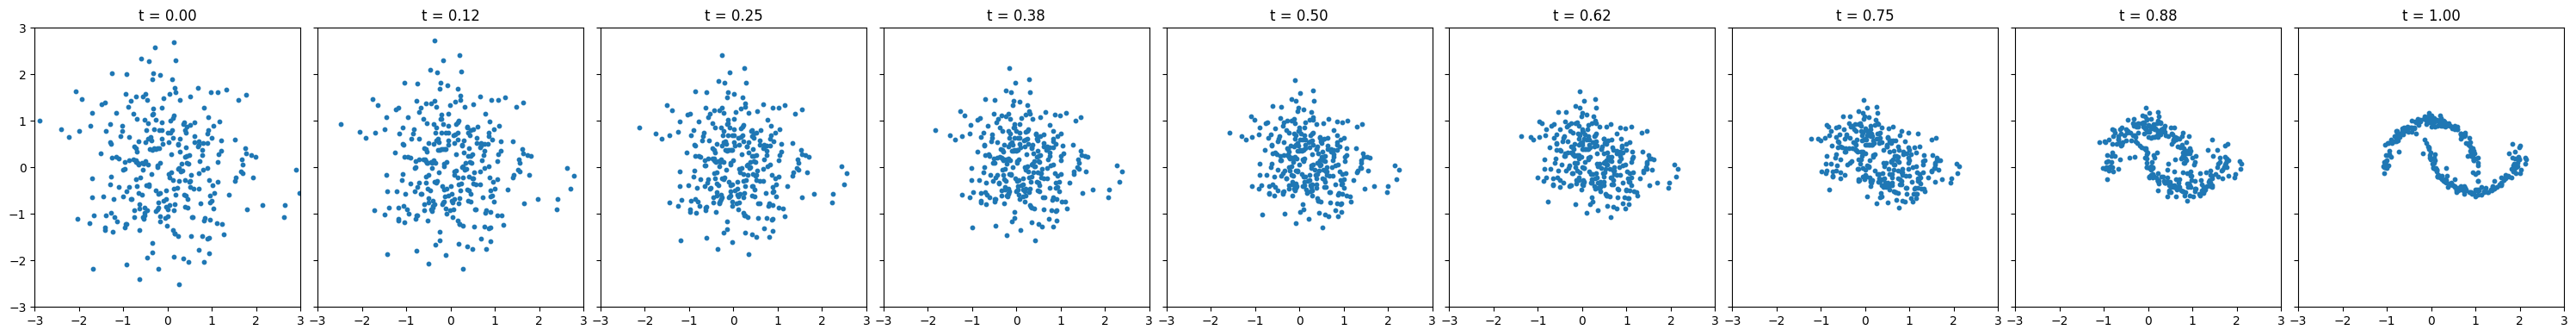

In [18]:
with torch.no_grad():
    x = torch.randn(300, 2)
    n_steps = 8
    step_factor = 4
    fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
    time_steps = torch.linspace(0, 1.0, n_steps*step_factor + 1)
    
    axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[0].set_title(f't = {time_steps[0]:.2f}')
    axes[0].set_xlim(-3.0, 3.0)
    axes[0].set_ylim(-3.0, 3.0)
    
    for i in range(n_steps):
        for j in range(step_factor):
            x = flow.step(x_t=x, t_start=time_steps[i*step_factor+j], t_end=time_steps[i*step_factor+j + 1])
        axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
        axes[i + 1].set_title(f't = {time_steps[i*step_factor+j + 1]:.2f}')
    
    plt.tight_layout()
    plt.show()


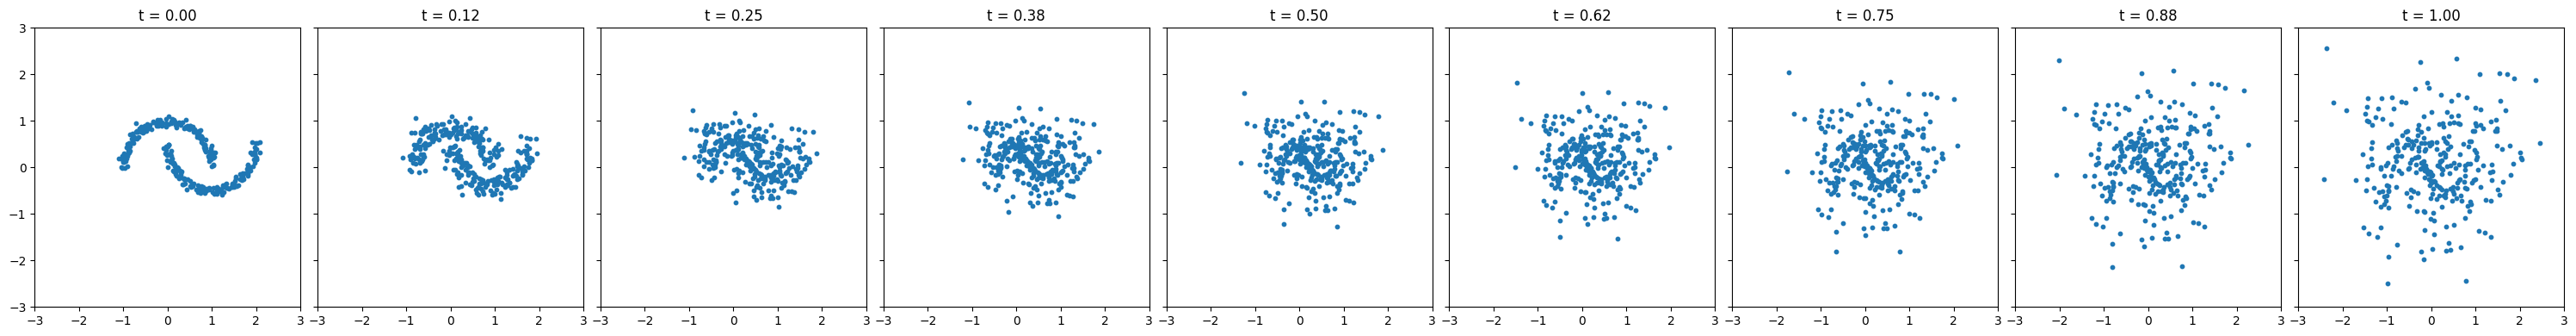

In [19]:
with torch.no_grad():
    x = Tensor(make_moons(300, noise=0.05)[0])
    n_steps = 8
    step_factor = 4
    fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
    time_steps = torch.linspace(0, 1.0, n_steps*step_factor + 1)
    
    axes[0].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
    axes[0].set_title(f't = {time_steps[0]:.2f}')
    axes[0].set_xlim(-3.0, 3.0)
    axes[0].set_ylim(-3.0, 3.0)
    
    for i in range(n_steps):
        for j in range(step_factor):
            x = flow.step_reverse(x_t=x, t_start=time_steps[i*step_factor+j], t_end=time_steps[i*step_factor+j + 1])
        axes[i + 1].scatter(x.detach()[:, 0], x.detach()[:, 1], s=10)
        axes[i + 1].set_title(f't = {time_steps[i*step_factor+j + 1]:.2f}')
    
    plt.tight_layout()
    plt.show()


In [26]:
class WrappedModel(ModelWrapper):
    def forward(self, x: torch.Tensor, t: torch.Tensor, **extras):
        t = t.reshape(-1, 1).expand(x.shape[0], 1)
        return self.model(t, x)

wrapped_vf = WrappedModel(flow)

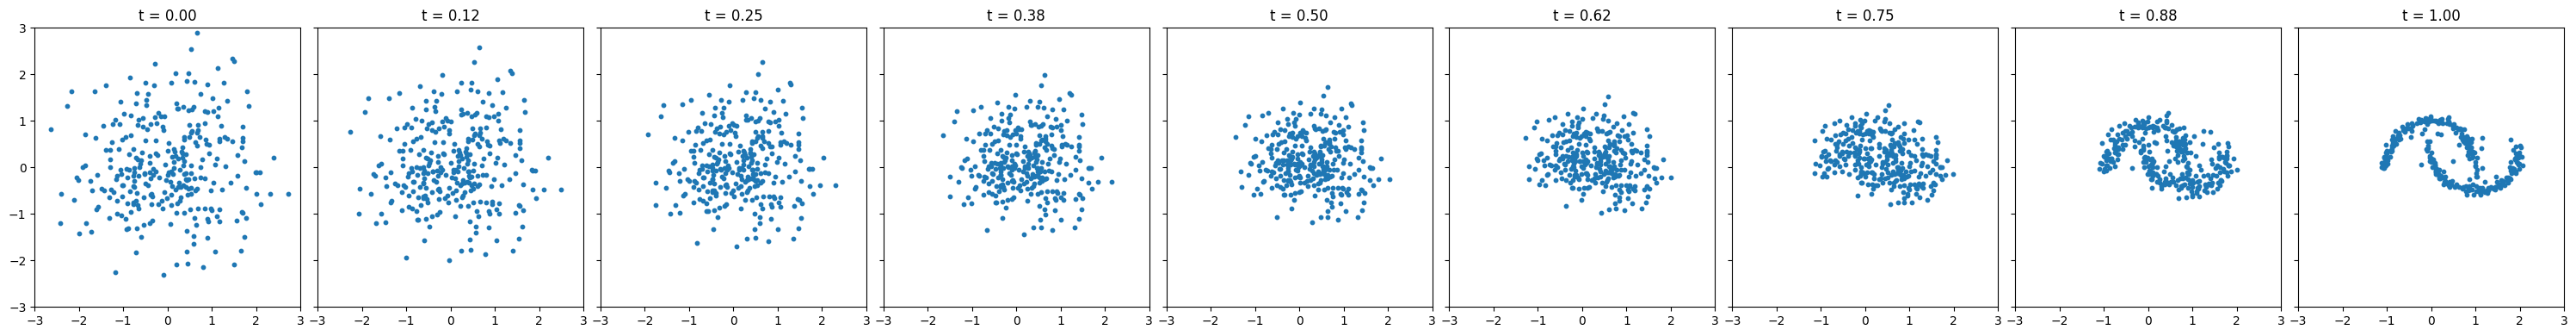

In [30]:
with torch.no_grad():
    # step size for ode solver
    step_size = 1/32
    batch_size = 300  # batch size
    
    T = torch.linspace(0,1,9)  # sample times
    
    x_init = torch.randn((batch_size, 2), dtype=torch.float32)
    solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
    sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model
    
    
    
    sol = sol.cpu().numpy()
    T = T.cpu()
    
    fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
    
    for i in range(len(T)):
        axes[i].scatter(sol[i,:,0], sol[i,:,1], s=10)
        axes[i].set_title(f't = {T[i]:.2f}')
        axes[i].set_xlim(-3.0, 3.0)
        axes[i].set_ylim(-3.0, 3.0)
        
            
    plt.tight_layout()
    plt.show()

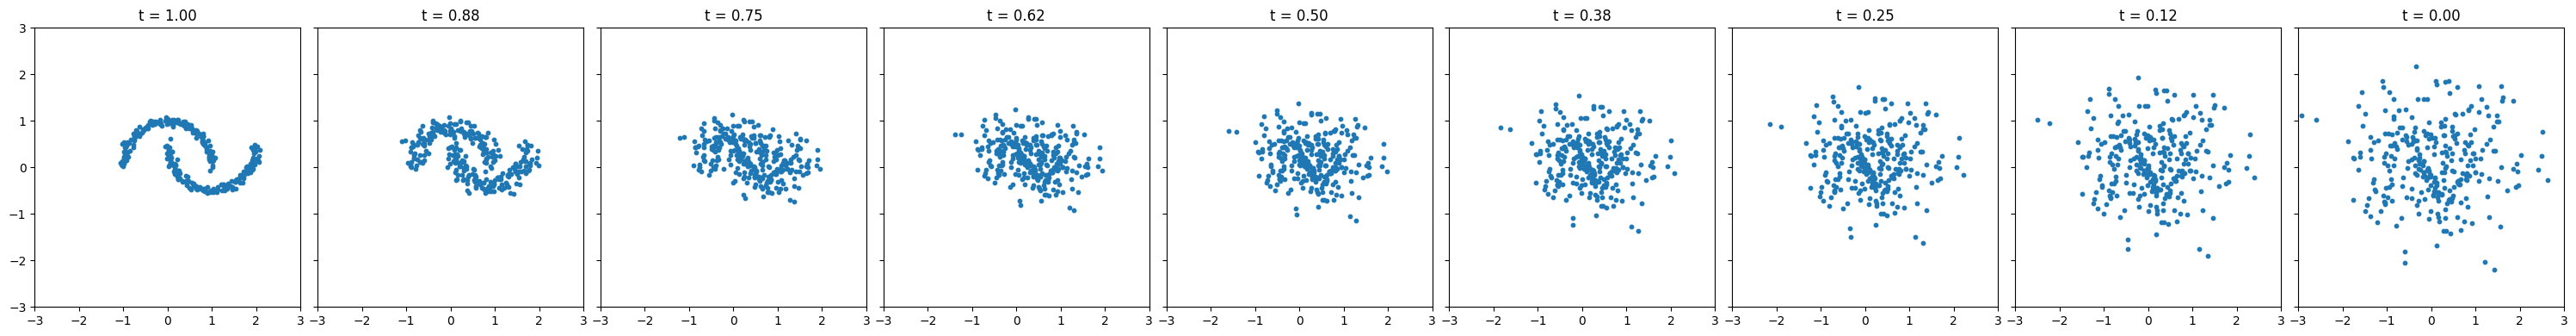

In [33]:
with torch.no_grad():
    # step size for ode solver
    step_size = 1/32
    batch_size = 300  # batch size
    
    T = torch.linspace(1,0,9)  # sample times
    
    x_init = Tensor(make_moons(batch_size, noise=0.05)[0])
    solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
    sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model
    
    
    
    sol = sol.cpu().numpy()
    T = T.cpu()
    
    fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
    
    for i in range(len(T)):
        axes[i].scatter(sol[i,:,0], sol[i,:,1], s=10)
        axes[i].set_title(f't = {T[i]:.2f}')
        axes[i].set_xlim(-3.0, 3.0)
        axes[i].set_ylim(-3.0, 3.0)
        
            
    plt.tight_layout()
    plt.show()

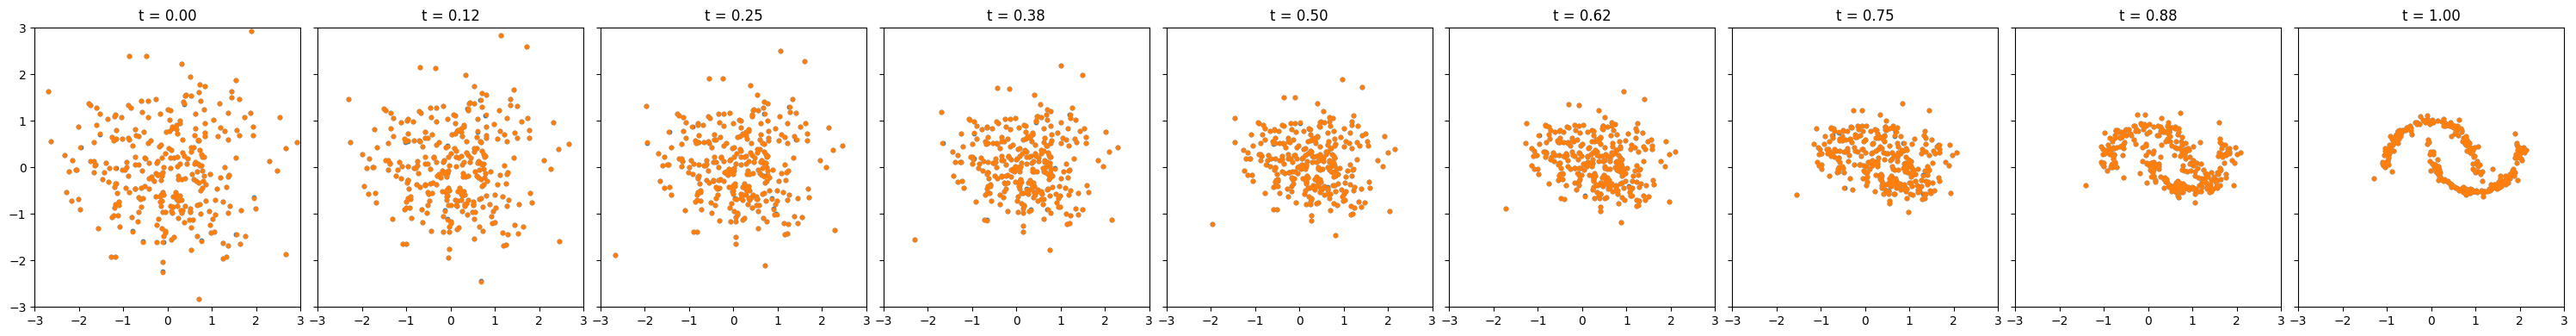

In [36]:
with torch.no_grad():
    # step size for ode solver
    step_size = 1/32
    batch_size = 300  # batch size
    
    T = torch.linspace(0,1,9)  # sample times
    
    x_init = torch.randn((batch_size, 2), dtype=torch.float32)
    solver = ODESolver(velocity_model=wrapped_vf)  # create an ODESolver class
    sol = solver.sample(time_grid=T, x_init=x_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model
    
    T_rev = torch.linspace(1,0,9)  # sample times
    
    z_init = sol[-1]
    sol_rev = solver.sample(time_grid=T_rev, x_init=z_init, method='midpoint', step_size=step_size, return_intermediates=True)  # sample from the model
    
    sol = sol.cpu().numpy()
    sol_rev = sol_rev.cpu().numpy()
    T = T.cpu()
    T_rev = T_rev.cpu()
    
    fig, axes = plt.subplots(1, n_steps + 1, figsize=(30, 4), sharex=True, sharey=True)
    
    for i in range(len(T)):
        axes[i].scatter(sol[i,:,0], sol[i,:,1], s=10, color="C0")
        axes[i].scatter(sol_rev[len(T) - i - 1,:,0], sol_rev[len(T) - i - 1,:,1], s=10, color="C1")
        axes[i].set_title(f't = {T[i]:.2f}')
        axes[i].set_xlim(-3.0, 3.0)
        axes[i].set_ylim(-3.0, 3.0)
        
            
    plt.tight_layout()
    plt.show()


In [39]:
import numpy as np
print(np.sqrt(((sol - sol_rev[::-1])**2).mean()))  # should be close to zero if the flow is symmetric

0.00046425321
